<a href="https://colab.research.google.com/github/anilkumarpanda/fairness_cb/blob/development/Testing_and_Remediating_Bias_constrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://githubtocolab.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Chapter-10/Testing_and_Remediating_Bias_constrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairness Code Breakfast : Testing and Remediating Bias in an XGBoost Credit Decision Model.

<img src="https://raw.githubusercontent.com/anilkumarpanda/fairness_cb/development/img/adog.JPG" alt="Alt Text" height="400">

This AI generated dog image has nothing to do with Fairness, but I hope I have your attention now.



# Fairness in Machine Learning ?

1. Is it important to consider fairness while developing models ?

2. Can it be achieved via a model ?

Code breakfast outline :

1. We’ll start off by training XGBoost on a variant of the credit card data.
2. We’ll then test for bias by checking for differences in performance and outcomes across demographic groups.
3. Once we confirm the existence of measurable levels of bias in our model predictions, we’ll start trying to fix, or remediate, that bias.
4. We employ pre-processing methods that attempt to fix the training data, model, and outcomes, respectively.
5. We’ll finish off by conducting bias-aware model selection that leaves us with a model that is both performant and more fair than the original model.

## 1. Setting the environment


In [75]:
# Installing the libraries
%pip install -q shap
%pip install -q 'XGBoost==1.6'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 2. Evaluating an XGBoost Model




### 2.1 Train a Credit Decision Model

Run the code/cells till #3. Measure Fairness without thinking too much. We need a model to start thinking about fairness.

In [76]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
import shap
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')

In [77]:
!wget https://raw.githubusercontent.com/anilkumarpanda/fairness_cb/development/credit_line_increase.csv

zsh:1: command not found: wget


In [78]:
# Read the dataset and convert string values to numerical.
#data = pd.read_csv('/content/credit_line_increase.csv')
data = pd.read_csv('credit_line_increase.csv')
data['SEX'] = np.where(data['SEX'] == 1, 'male', 'female')
race_map = {1: 'hispanic', 2: 'black', 3: 'white', 4: 'asian'}
data['RACE'] = data['RACE'].apply(lambda x: race_map[x])

In [79]:
# Modify the data so there is a distributional difference
# between borrowers of different race/ethnicities.

new_limit_bal = data['LIMIT_BAL'] - 20000*np.random.randn(len(data))
new_limit_bal[new_limit_bal <= 10000] = 10000
data['LIMIT_BAL'] = np.where((data['RACE'] == 'hispanic') | (data['RACE'] == 'black'),
                             new_limit_bal,
                             data['LIMIT_BAL'])

for i in range(1, 7):
    delta = 1000*np.random.randn(len(data))
    new_pay = data[f'PAY_AMT{i}'] - delta
    new_pay[new_pay < 0] = 0

    new_bill = data[f'BILL_AMT{i}'] - delta
    new_bill[new_bill < 0] = 0

    data[f'PAY_AMT{i}'] = np.where((data['RACE'] == 'hispanic') | (data['RACE'] == 'black'),
                                   new_pay,
                                   data[f'PAY_AMT{i}'])
    data[f'BILL_AMT{i}'] = np.where((data['RACE'] == 'hispanic') | (data['RACE'] == 'black'),
                                    new_bill,
                                    data[f'BILL_AMT{i}'])


In [80]:
# Split the data into train validation and test
seed = 12345
np.random.seed(seed)

split_train_test = 2/3

split = np.random.rand(len(data)) < split_train_test
train = data[split].copy()
test = data[~split].copy()

split_test_valid = 1/2

split = np.random.rand(len(test)) < split_test_valid
valid = test[split].copy()
test = test[~split].copy()

del data

print(f"Train/Validation/Test sizes: {len(train)}/{len(valid)}/{len(test)}")

Train/Validation/Test sizes: 19919/5045/5036


Generally speaking, for most business applications, it’s safest not to use demographic information as model inputs. Not only is this legally risky in spaces like consumer credit, housing, and employment, it also implies that business decisions should be based on race or gender—and that’s dangerous territory.

It’s also true, however, that using demographic data in model training can decrease bias, and we’ll see a version of that when we try out in-processing bias remediation. There also may be certain kinds of decisions that should be based on demographic information, such as those about medical treatments.
But this is not the case here.

However, having this information is important to measure bias.

In [81]:
id_col = 'ID'
groups = ['SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE']
target = 'DELINQ_NEXT'
features = [col for col in train.columns if col not in groups + [id_col, target]]

dtrain = xgb.DMatrix(train[features],
                     label=train[target])

dvalid = xgb.DMatrix(valid[features],
                     label=valid[target])

In [82]:
corr = pd.DataFrame(train[features + [target]].corr(method='spearman')[target]).iloc[:-1]

def get_monotone_constraints(data, target, corr_threshold):
    """Calculate monotonic constraints.
    Monotonic constraints help in explainability.
    It enforces the model to maintain certain relationship.

    Using a cutoff on Spearman correlation between features and target,
    return a tuple ready to pass into XGBoost.

    Spearman correlation is nice because it considers monotonicity rather than
    linearity (as is the case with Pearson correlation coefficient).


    Args:
        data (pd.DataFrame): A DataFrame containing the features in the order they appear to XGBoost, as well as the target variable.
        target (str): The name of the column with the target variable in 'data'.
        corr_threshold (float): The Spearman correlation threshold.

    Returns:
        tuple: A tuple with values in {-1, 0, 1}, where each element corresponds to a column in data (excluding the target itself). Ready to pass into xgb.train()

    """

    corr = pd.Series(data.corr(method='spearman')[target]).drop(target)
    monotone_constraints = tuple(np.where(corr < -corr_threshold,
                                          -1,
                                          np.where(corr > corr_threshold,
                                                   1,
                                                   0)))
    return monotone_constraints

correlation_cutoff = 0.1

monotone_constraints = get_monotone_constraints(train[features+[target]],
                                                target,
                                                correlation_cutoff)

In [83]:
# Feed the model the global bias
# refers to the initial prediction value assigned to all
# instances before the boosting process begins.
# It acts as a starting point for the gradient boosting algorithm.

base_score = train[target].mean()

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'subsample': 0.6,
    'colsample_bytree': 1.0,
    'max_depth': 5,
    'base_score': base_score,
    'monotone_constraints': dict(zip(features, monotone_constraints)),
    'seed': seed
}

# Train using early stopping on the validation dataset.
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

model_constrained = xgb.train(params,
                              dtrain,
                              num_boost_round=200,
                              evals=watchlist,
                              early_stopping_rounds=10,
                              verbose_eval=False)

train[f'p_{target}'] = model_constrained.predict(dtrain)
valid[f'p_{target}'] = model_constrained.predict(dvalid)
test[f'p_{target}'] = model_constrained.predict(xgb.DMatrix(test[features], label=test[target]))

In [84]:
# Select the optimal probability cutoff by maximizing the F1 score on validation data.
# You can choose any other method as well.

def perf_metrics(y_true, y_score, pos=1, neg=0, res=0.01):
    """
    Calculates precision, recall, and f1 given outcomes and probabilities.

    Args:
        y_true: Array of binary outcomes
        y_score: Array of assigned probabilities.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.

    Returns:
        Pandas dataframe of precision, recall, and f1 values.
    """

    eps = 1e-20 # for safe numerical operations

    # init p-r roc frame
    prauc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])

    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        decisions = np.where(y_score > cutoff , 1, 0)

        # calculate confusion matrix values
        tp = np.sum((decisions == pos) & (y_true == pos))
        fp = np.sum((decisions == pos) & (y_true == neg))
        tn = np.sum((decisions == neg) & (y_true == neg))
        fn = np.sum((decisions == neg) & (y_true == pos))

        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))


        # add new values to frame
        prauc_frame = prauc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1},
                                          ignore_index=True)

    return prauc_frame


model_metrics = perf_metrics(y_true=valid[target], y_score=model_constrained.predict(dvalid))


In [85]:
model_metrics.loc[model_metrics['f1'].idxmax()]

cutoff       0.260000
recall       0.610773
precision    0.541602
f1           0.574112
Name: 26, dtype: float64

As we set the cutoff to 0.26 , all predictions above 0.26 are not going to get the credit line increase on offer. All predictions that are 0.26 or below will be accepted.

Text(0.5, 0, 'Score Cutoff')

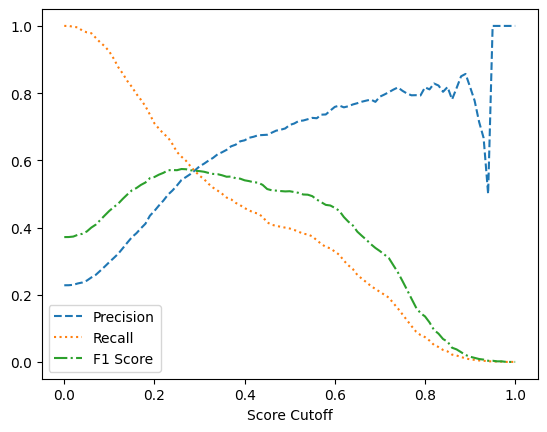

In [86]:
# Since the Disparate Impact Analysis(DIA) analysis will focus on model outcomes
# (rather than scores), choose a cutoff in probability space.

best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']
best_cut_original = best_cut

fig, ax = plt.subplots()
ax.plot(model_metrics['cutoff'], model_metrics['precision'], label='Precision',linestyle='--')
ax.plot(model_metrics['cutoff'], model_metrics['recall'], label='Recall',linestyle=':')
ax.plot(model_metrics['cutoff'], model_metrics['f1'], label='F1 Score',linestyle='-.')
ax.legend(loc=3)
ax.set_xlabel('Score Cutoff')


In [87]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):
    """
    Creates confusion matrix from pandas dataframe of y and yhat values,
    can be sliced by a variable and level.

    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, default None.
        level: Value of by variable to slice frame before creating confusion matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5.

    Returns:
        Confusion matrix as pandas dataframe.
    """

    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list],
                            index=['predicted: ' + str(i) for i in level_list])

    # don't destroy original data
    frame_ = frame.copy(deep=True)

    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)

    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]

    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]

    return cm_frame

get_confusion_matrix(test, target, f'p_{target}', cutoff=best_cut)

,actual: 1,actual: 0
predicted: 1,655,592
predicted: 0,442,3347


## 3. Detecting Bias


Imagine that the model you created above will be used provide loans. So it is important to measure the models for fairness. Incase it is found that the model has bias, we can also look at some bias mitigating technique.

Lets first start by measuring bias.
In the domain of fairness, there a lot of metrics that can be considered depending on the problem.

Some of them include :

- Prevalence: '(tp + fn) / (tp + tn +fp + fn)', # How much default actually happens for this group

- Accuracy: '(tp + tn) / (tp + tn + fp + fn)', # how often the model predicts default and non-default correctly for this group

- True Positive Rate: 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default

- Precision: 'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default

- Specificity: 'tn / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default

- Negative Predicted Value: 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default

- False Positive Rate: 'fp / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default

- False Discovery Rate: 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

- False Negative Rate: 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default

- False Omissions Rate: 'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default


Are you feeling overwhelmed with all these metrics ??

<img src="https://raw.githubusercontent.com/anilkumarpanda/fairness_cb/development/img/blue_cat.JPG" alt="Sad Bleu Cat" height="400">



<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTkPZ1nf-X_zq_stiiNqv7opkVZU7wEJsMcjAhJSrq2ug&s" alt="Andrew Ng" height="400">

The Fairness Decision Tree can be a good starting point. ![fairness decision tree](https://raw.githubusercontent.com/anilkumarpanda/fairness_cb/development/fairness_tree.png)

Other more practical metrics include AIR,SMD etc. These are likely more aligned to legal standards and are used to analyze differences in outcomes across groups, using traditional measures of statistical and practical significance. 
We’ll pair two well-known practical bias-testing measures, AIR and SMD, with chi-squared and t-tests, respectively. 

AIR : Adverse Impact Ratio

SMD : Statistical Measures of Disparate Impact.

We will cover these definitions later in the notebook.

Confusion Matrix with Disparity Metrics

Similar to normal confusion matrix, we can also create a confusion matrix with various disparity metrics as well.


In [88]:
metric_dict = {
'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much default actually happens for this group
'Accuracy': '(tp + tn) / (tp + tn + fp + fn)', # how often the model predicts default and non-default correctly for this group
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default
'Precision': 'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default
'Specificity': 'tn / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default

'False Positive Rate': 'fp / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default
'False Omissions Rate': 'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default
}


def confusion_matrix_parser(expression):

    # tp | fp       cm_dict[level].iat[0, 0] | cm_dict[level].iat[0, 1]
    # -------  ==>  --------------------------------------------
    # fn | tn       cm_dict[level].iat[1, 0] | cm_dict[level].iat[1, 1]

    expression = expression.replace('tp', 'cm_dict[level].iat[0, 0]')\
                           .replace('fp', 'cm_dict[level].iat[0, 1]')\
                           .replace('fn', 'cm_dict[level].iat[1, 0]')\
                           .replace('tn', 'cm_dict[level].iat[1, 1]')

    return expression

In [89]:
# initialize dict of confusion matrices and corresponding rows of dataframe
sex_confusion_mats = {'male': get_confusion_matrix(test, target,
                                                   f'p_{target}', by='SEX',
                                                   level='male', cutoff=best_cut),
                      'female': get_confusion_matrix(test, target,
                                                     f'p_{target}', by='SEX',
                                                     level='female', cutoff=best_cut)}

def confusion_matrix_metrics(cm_dict, metric_dict):
    levels = list(cm_dict.keys())

    metrics_frame = pd.DataFrame(index=levels) # frame for metrics

    for level in levels:
        for metric in metric_dict.keys():

            # parse metric expressions into executable pandas statements
            expression = confusion_matrix_parser(metric_dict[metric])

            # dynamically evaluate metrics to avoid code duplication
            metrics_frame.loc[level, metric] = eval(expression)

    return metrics_frame

sex_confusion_metrics = confusion_matrix_metrics(sex_confusion_mats, metric_dict)

In [90]:
sex_confusion_metrics

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
male,0.238264,0.779404,0.599576,0.532957,0.835653,0.869655,0.164347,0.467043,0.400424,0.130345
female,0.204583,0.804583,0.595200,0.519553,0.858436,0.891834,0.141564,0.480447,0.404800,0.108166


Let us create the confusion matrix with disparity metrics for Race groups.


In [91]:
race_levels = list(race_map.values())
race_confusion_mats = {level: get_confusion_matrix(test, target, f'p_{target}', by='RACE',
                                                   level=level, cutoff=best_cut) for level in race_levels}
race_confusion_metrics = confusion_matrix_metrics(race_confusion_mats, metric_dict)
race_confusion_metrics

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
hispanic,0.399393,0.725986,0.637975,0.663158,0.784512,0.765189,0.215488,0.336842,0.362025,0.234811
black,0.386707,0.720040,0.635417,0.638743,0.773399,0.770867,0.226601,0.361257,0.364583,0.229133
white,0.107075,0.829828,0.470238,0.307393,0.872948,0.932165,0.127052,0.692607,0.529762,0.067835
asian,0.101010,0.853199,0.533333,0.350877,0.889139,0.944312,0.110861,0.649123,0.466667,0.055688


The metrics are quite different across groups.
E.g the precision rates.  White & Asian on one hand while hispanic and black on the other.

we are starting to get a hint that our model is predicting more defaults for Black and Hispanic people, but it’s still hard to tell if it’s doing a good or equitable job.

To understand if this is actually problematic ,we’ll follow methods from traditional bias testing and divide the value for each group by the corresponding value for the control group and apply the four-fifths rule as a guide. In this case, we assume the control group is white people.

Strictly speaking, in the employment context, the control group is the most favored group in an analysis, not necessarily white people or males. There may also be other reasons to use control groups that are not white people or males. Choosing the control or reference group for a bias-testing analysis is a difficult task, best done in concert with legal, compliance, social science experts, or stakeholders.

Now that we have the confusion matrix, let us identify the metrics that "problematic".

The definition of problematic metric stems from the Four-fifths rule.

The four-fifths rule is a guideline released in the 1978 Uniform Guidelines on Employee Selection Procedures (UGESP) by the Equal Employment Opportunity Commission (EEOC). Part 1607.4 of the UGESP states that “a selection rate for any race, sex, or ethnic group which is less than four-fifths (4/5) (or eighty percent) of the rate for the group with the highest rate will generally be regarded by the Federal enforcement agencies as evidence of adverse impact.”

For better or worse, the value of 0.8 for adverse impact —which compares event rates, like job selection or credit approval—has become a widespread benchmark for bias in ML systems.



In [92]:
# @title Confusion Matrix for Race Group : Highlight disparity

race_disparity_frame = race_confusion_metrics/race_confusion_metrics.loc['white', :]
race_disparity_frame.columns=[col + ' Disparity' for col in race_confusion_metrics.columns]

# small utility function to format pandas table output
def disparate_red(val, parity_threshold_low=0.8, parity_threshold_hi=1.20):
    color = 'grey' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color

race_disparity_frame.style.applymap(disparate_red)

,Prevalence Disparity,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
hispanic,3.730048,0.874863,1.356706,2.157362,0.898693,0.820873,1.696062,0.486339,0.683374,3.461486
black,3.611567,0.867698,1.351266,2.077938,0.885962,0.826965,1.783528,0.521590,0.688202,3.377775
white,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
asian,0.943362,1.028163,1.134177,1.141461,1.018547,1.013031,0.872567,0.937217,0.880899,0.820931


We see no out-of-range values for Asian people. This means that the model performs fairly equitably across white and Asian people. However, we do see glaring out-of-range values for Hispanic and Black people for precision, false positive rate, false discovery rate, and false omissions rate disparities. While applying the four-fifths rule can help us flag these values, it really can’t help us interpret them. For this, we’ll have to rely on our human brains to think through these results.

e.g Given that prevalence of defaults in the data is so much higher for Black and Hispanic people, one thing these results suggest is that our model learned more about defaults in these groups, and predicts defaults at a higher rate in these groups.

In [93]:
# @title Confusion Matrix for Gender Group : Highlight disparity

sex_disparity_frame = sex_confusion_metrics/sex_confusion_metrics.loc['male', :]
sex_disparity_frame.columns=[col + ' Disparity' for col in sex_confusion_metrics.columns]

# small utility function to format pandas table output
def disparate_red(val, parity_threshold_low=0.8, parity_threshold_hi=1.20):
    color = 'grey' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color

sex_disparity_frame.style.applymap(disparate_red)

,Prevalence Disparity,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
female,0.858640,1.032305,0.992701,0.974850,1.027264,1.025503,0.861370,1.028699,1.010929,0.829844


### Fair Lending Disparity Analysis

Statistically significant differences in outcomes or mean scores is one of the most common legally recognized measures of discrimination, especially in areas like credit lending, where algorithmic decision making has been regulated for decades. 

By using practical tests and effect size measures, like AIR and SMD, with statistical significance tests, we get two pieces of information: the magnitude of the observed difference, and whether it’s statistically significant, i.e., likely to be seen again in other samples of data.

AIR : Adverse Impact Ratio

* AIR is often applied to categorical outcomes, like credit lending or hiring outcomes, where someone either receives a positive outcome or not. 
* AIR is defined as the rate of positive outcomes for a protected group, like minorities or women, divided by the same rate of positive outcomes for a control group, like white people or men. 
* According to the four-fifths rule, we look for the AIR to be above 0.8.  An AIR below 0.8 points to a serious problem. We then test whether this difference will probably be seen again or if it’s due to chance using a chi-squared test.

SMD : Statistical Measures of Disparate Impact.

SMD is defined as the mean score for a protected group minus the mean score for a control group, with that quantity divided by a measure of the standard deviation of the score.

* SMD and t-tests are often used on predictions from regression models, or on numeric quantities like wages, salaries, or credit limits. We’ll apply SMD and t-tests to our model’s predicted probabilities for demonstration purposes and to get some extra information about bias in our model.

* SMD has well-known cutoffs at magnitudes of 0.2, 0.5, and 0.8 for small, medium, and large differences, respectively. We’ll use a t-test to decide whether the effect size measured by SMD is statistically significant.



In [94]:
from scipy.stats import ttest_ind, chisquare, fisher_exact, chi2_contingency


def air_statistical_signif(group_count, group_favorable, reference_count, reference_favorable):
    # Perform a chi-square test 
    # (or Fisher's exact when cells in the contingency test have less than 30 individuals in them).
    
    group_unfavorable = group_count - group_favorable
    reference_unfavorable = reference_count - reference_favorable
    
    contingency_table = np.array([[group_favorable, group_unfavorable], 
                                  [reference_favorable, reference_unfavorable]])
    
    if np.min(contingency_table) < 30:
        _, p = fisher_exact(contingency_table)
    else:
        _, p, _, _ = chi2_contingency(contingency_table)
    
    return p

def smd_statistical_signif(group_scores, reference_scores):
    # Perform a one-sided t-test. An outcome of 1 is assumed to be favorable. 
    
    # We do not assume that the two scores have equal variance. Furthermore, we are testing 
    # against the alternative hypothesis that the group receives lower scores than the reference
    # group.
    _, p = ttest_ind(group_scores, reference_scores, equal_var=False, alternative='less')
    return p

def fair_lending_disparity(frame, y, yhat, demo_name, groups, reference_group, cutoff=0.5, favorable_outcome=0):
    """ 
    Creates a table of fair lending disparity metrics (AIR and SMD).
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values with group membership.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        demo_name: The name of the column containing the group information
        groups: The names of the groups in the demo_name column.
        reference_group: The control group.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 
        favorable_outcome: The value {0, 1} that corresponds to a desirable outcome.

    Returns:
        A DataFrame summarizing the fair lending metrics analysis
    """
    
    protected_groups = [group for group in groups if group != reference_group]
    groups_ordered = protected_groups + [reference_group]   
    
    temp_frame = frame.copy()
    temp_frame['model_outcome'] = np.where(temp_frame[yhat] <= cutoff, 0, 1)
    temp_frame['fav_outcome'] = temp_frame['model_outcome'] == favorable_outcome
    temp_frame['fav_score'] = temp_frame[yhat] if favorable_outcome else 1-temp_frame[yhat]
    
    disparity_table = pd.DataFrame(index=groups_ordered)
    
    disparity_table['Count'] = [len(temp_frame.loc[temp_frame[demo_name] == group]) for group in groups_ordered]
    disparity_table['Favorable Outcomes'] = [temp_frame.loc[temp_frame[demo_name] == group]['fav_outcome'].sum() 
                                             for group in groups_ordered]
    disparity_table['Favorable Rate'] = [disparity_table['Favorable Outcomes'][group]/disparity_table['Count'][group] 
                                         for group in groups_ordered]
    disparity_table['Mean Score'] = [temp_frame.loc[temp_frame[demo_name] == group][yhat].mean() 
                                             for group in groups_ordered]
    disparity_table['Std Score'] = [temp_frame.loc[temp_frame[demo_name].isin([reference_group, group])][yhat].std() 
                                             for group in groups_ordered]
    try:
        disparity_table['AIR'] = [disparity_table['Favorable Rate'][group]/disparity_table['Favorable Rate'][reference_group] 
                                  for group in groups_ordered]
    except:
        disparity_table['AIR'] = np.nan
        
    disparity_table['AIR p-value'] = [air_statistical_signif(disparity_table['Count'][group], 
                                                             disparity_table['Favorable Outcomes'][group],
                                                             disparity_table['Count'][reference_group],
                                                             disparity_table['Favorable Outcomes'][reference_group])
                                      for group in groups_ordered]

    disparity_table['SMD'] = [(disparity_table['Mean Score'][group] - 
                               disparity_table['Mean Score'][reference_group]) / 
                              disparity_table['Std Score'][group]
                              for group in groups_ordered]
    
    disparity_table['SMD p-value'] = [smd_statistical_signif(temp_frame.loc[temp_frame[demo_name] == group]['fav_score'],
                                                             temp_frame.loc[temp_frame[demo_name] == reference_group]['fav_score'])
                                      for group in groups_ordered]

    return disparity_table
    

Let us see how the disparity looks like for training set ?

In [95]:
# Calculate the AIR and SMD scores across Train, Test & Validation datasets.

fair_lending_disparity(train, y=target, yhat=f'p_{target}',
                       demo_name='RACE', groups=race_levels, reference_group='white',
                       cutoff=best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,3828,2291,0.598485,0.293440,0.200466,0.707605,5.460221e-169,0.582584,1.495956e-155
black,3795,2292,0.603953,0.290833,0.199664,0.714070,5.964702e-162,0.571868,9.077000e-149
asian,6181,5259,0.850833,0.173872,0.162106,1.005964,4.505482e-01,-0.017151,8.291354e-01
white,6115,5172,0.845789,0.176652,0.163658,1.000000,1.000000e+00,0.000000,5.000000e-01


It clear that there is a big difference in scores for Black and Hispanic people versus scores for white and Asian people.

While our data is simulated, very sadly, this is not atypical in consumer finance.

It is immediately obvious that Black and Hispanic people have higher mean scores and lower favorable rates than white and Asian people, while all four groups have similar standard deviations for scores. 

Are these differences big enough to be a bias problem? 

That’s where our practical significance tests come in. AIR and SMD are both calculated in reference to white people. That’s why white people have scores of 1.0 and 0.0 for these, respectively.

Looking at AIR, both Black and Hispanic AIRs are below 0.8. Big red flag! SMDs for those two groups are around 0.5, meaning a medium difference in scores between groups. That’s not a great sign either. We’d like for those SMD values to be below or around 0.2, signifying a small difference.

Can you calculate the disparity for test and validation set ?

In [96]:
# @title Excercise : Disparity for validation set
fair_lending_disparity(valid, y=target, yhat=f'p_{target}',
                       demo_name='RACE', groups=race_levels, reference_group='white',
                       cutoff=best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,1016,610,0.600394,0.290456,0.204616,0.726036,3.513458e-37,0.507062,1.137735e-33
black,1008,633,0.627976,0.280488,0.203442,0.759391,1.069313e-29,0.460991,7.053854e-28
asian,1455,1209,0.830928,0.187016,0.175111,1.004813,8.088640e-01,0.001787,4.804269e-01
white,1566,1295,0.826948,0.186703,0.175511,1.000000,1.000000e+00,0.000000,5.000000e-01


In [97]:
# @title Excercise : Disparity for test set

fair_lending_disparity(test, y=target, yhat=f'p_{target}',
                       demo_name='RACE', groups=race_levels, reference_group='white',
                       cutoff=best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,989,609,0.615774,0.291994,0.205374,0.736394,6.803832e-36,0.528829,4.311283e-35
black,993,611,0.615307,0.279935,0.199937,0.735836,4.343885e-36,0.482898,4.564904e-30
asian,1485,1257,0.846465,0.177847,0.169855,1.012274,4.677908e-01,-0.032609,8.162671e-01
white,1569,1312,0.836201,0.183386,0.172153,1.000000,1.000000e+00,0.000000,5.000000e-01


## 4. Remediating Model Bias


<img src="https://raw.githubusercontent.com/anilkumarpanda/fairness_cb/development/img/ds_cat.JPG" alt="Alt Text" height="400">

A cat data scientist at work.



There are many potential ways to remediate bias. Some of the most common include pre-, in-, and postprocessing, and model selection:

1. Preprocessing : Rebalancing, reweighing, or resampling training data so that demographic groups are better represented or positive outcomes are distributed more equitably.

2. In-processing : Any number of alterations to ML training algorithms, including constraints, regularization and dual loss functions, or incorporation of adversarial modeling information, that attempt to generate more balanced outputs or performance across demographic groups.

3. Postprocessing :Changing model predictions directly to create less biased outcomes.

4. Model selection : Considering bias along with performance when selecting models. Typically, it’s possible to find a model with good performance and fairness characteristics if we measure bias and performance across a large set of hyperparameter settings and input features.

### 4.1 Pre-Processing

The first bias-remediation technique we’ll try is a preprocessing technique known as reweighing. 

It was published first by Faisal Kamiran and Toon Calders in their 2012 paper, “Data Preprocessing Techniques for Classification Without Discrimination”. 

The idea of reweighing is to make the average outcome across groups equal using observation weights and then retrain the model. 

In [98]:
def reweight_dataset(frame, y, demo_name, groups):
    """
    Generates a weight for each observation according to the reweighting algorithm of
    Kamiran and Kalders 2012, Data preprocessing techniques for classification without discrimination.

    Args:
        frame: Pandas dataframe of actual (y) and group information.
        y: Name of actual value column (assumed to be binary).
        demo_name: The name of the column containing the group information
        groups: The names of the groups in the demo_name column.

    Returns:
        A Series containing the new observation weights.
    """

    n = len(frame)

    freq_dict = {'pos': len(frame.loc[frame[y] == 1])/n,
                 'neg': len(frame.loc[frame[y] == 0])/n}

    freq_dict.update({group: frame[demo_name].value_counts()[group]/n for group in groups})

    weights = pd.Series(np.ones(n), index=frame.index)

    for label in [0, 1]:
        for group in groups:
            label_name = 'pos' if label == 1 else 'neg'
            freq = frame.loc[frame[y] == label][demo_name].value_counts()[group]/n
            weights[(frame[y] == label) & (frame[demo_name] == group)] *= freq_dict[group]*freq_dict[label_name]/freq

    return weights

In [99]:
train_weights = reweight_dataset(train, target, 'RACE', race_levels)

In [100]:
for race in race_levels:
    print(f"Mean outcome for {race}: {np.round(train.loc[train['RACE'] == race][target].mean(), 3)}")

    weighted_target = np.multiply(train.loc[train['RACE'] == race][target],
    train_weights.loc[train['RACE'] == race])

    print(f"Mean outcome for {race} - reweighted: {np.round(weighted_target.mean(), 3)} \n")

Mean outcome for hispanic: 0.398
Mean outcome for hispanic - reweighted: 0.22 

Mean outcome for black: 0.4
Mean outcome for black - reweighted: 0.22 

Mean outcome for white: 0.112
Mean outcome for white - reweighted: 0.22 

Mean outcome for asian: 0.107
Mean outcome for asian - reweighted: 0.22 



In [101]:
dtrain = xgb.DMatrix(train[features],
                     label=train[target],
                     weight=train_weights)


model_reweighted = xgb.train(params,
                             dtrain,
                             num_boost_round=100,
                             evals=watchlist,
                             early_stopping_rounds=10,
                             verbose_eval=False)

In [102]:
reweighted_model_metrics = perf_metrics(y_true=valid[target], y_score=model_reweighted.predict(dvalid))
reweighted_best_cut = reweighted_model_metrics.loc[reweighted_model_metrics['f1'].idxmax(), 'cutoff']

In [103]:
test[f'p_{target}_reweighted'] = model_reweighted.predict(xgb.DMatrix(test[features], label=test[target]))

fair_lending_disparity(test, y=target, yhat=f'p_{target}_reweighted',
                       demo_name='RACE', groups=race_levels, reference_group='white',
                       cutoff=reweighted_best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
hispanic,989,690,0.697674,0.261248,0.193556,0.861252,8.214824e-11,0.317753,5.203472e-14
black,993,706,0.710977,0.250055,0.188312,0.877673,7.775867e-09,0.267162,1.298820e-10
asian,1485,1215,0.818182,0.193657,0.168962,1.010014,5.965906e-01,-0.036034,8.403550e-01
white,1569,1271,0.810070,0.199745,0.171279,1.000000,1.000000e+00,0.000000,5.000000e-01


When we trained XGBoost on the unweighted data, we saw some problematic AIR values. 

* Originally, the AIR was around 0.73 for Black and Hispanic people. These values are not great—signifying that for every 1,000 credit products the model extends to white people, this model only accepts applications from about 730 Hispanic or Black people.

* This level of bias is ethically troubling, but it could also give rise to legal troubles in consumer finance, hiring, or other areas that rely on traditional legal standards for bias testing. The four-fifths rule—while flawed and imperfect—tells us we should not see values below 0.8 for AIR. 

Luckily, in our case, reweighing provides good remediation results.

However , how does that affect the model performance ?

We can check that by looking at F1 scores at diffrent re-weighting values.


In [104]:
# @title Excercise : Reweighting Scheme and its effect on AIR
# Conduct a similar experiment with the magnitude of the reweighing scheme.

magnitudes = np.arange(0, 1.5, 0.10)
scores = []
trees = []

air_black_ii = []
air_hispanic_ii = []
air_asian_ii = []

dtest = xgb.DMatrix(test[features], label=test[target])

for mag in magnitudes:

    weight_change = 1 - train_weights
    new_train_weights = 1 - mag*weight_change

    dtrain = xgb.DMatrix(train[features],
                     label=train[target],
                     weight=new_train_weights)


    model = xgb.train(params,
                      dtrain,
                      num_boost_round=200,
                      evals=watchlist,
                      early_stopping_rounds=10,
                      verbose_eval=False)

    model_metrics = perf_metrics(y_true=valid[target],
                                 y_score=model.predict(dvalid, iteration_range=(0, model.best_iteration)))
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

    test[f'p_{target}_lam_test'] = model.predict(dtest, iteration_range=(0, model.best_iteration))

    air_table = fair_lending_disparity(test, y=target, yhat=f'p_{target}_lam_test',
                                       demo_name='RACE', groups=race_levels, reference_group='white',
                                       cutoff=best_cut)

    scores.append(model_metrics['f1'].max())
    trees.append(model.best_ntree_limit)

    air_black_ii.append(air_table.loc['black']['AIR'])
    air_hispanic_ii.append(air_table.loc['hispanic']['AIR'])
    air_asian_ii.append(air_table.loc['asian']['AIR'])


Text(0, 0.5, 'Num Trees')

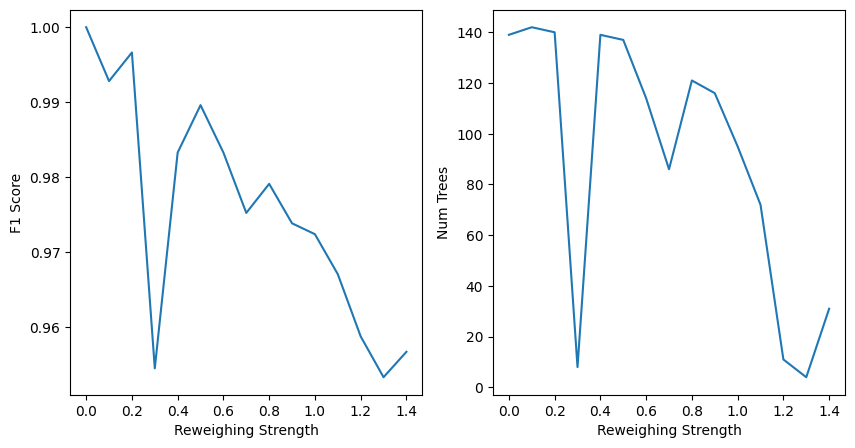

In [105]:
# @title Excercise : Reweighting effect on model performance

# This plot shows a relative drop in F1 score down to 94% of the original value.
# Meanwhile, black and Hispanic AIRs go from 0.72 to 0.9!

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(magnitudes, [score/scores[0] for score in scores])
axs[0].set_xlabel('Reweighing Strength')
axs[0].set_ylabel('F1 Score')

axs[1].plot(magnitudes, trees)
axs[1].set_xlabel('Reweighing Strength')
axs[1].set_ylabel('Num Trees')

#fig.savefig('../Data/Data/Figures/preprocessing_summary_i.svg')

(0.688812147031986, 1.05)

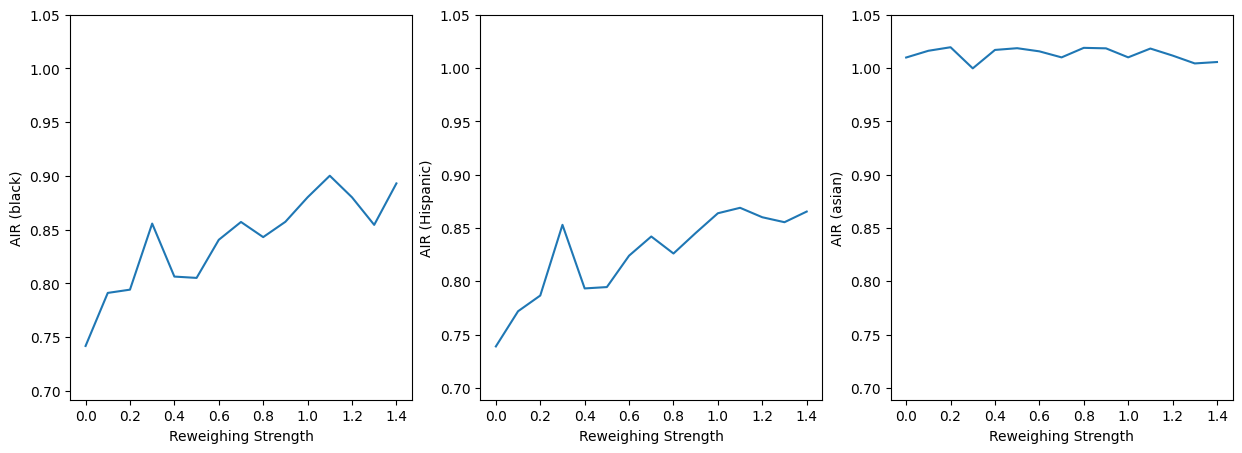

In [106]:
# @title Excercise : Reweighting effect on AIR across Race groups

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(magnitudes, air_black_ii)
axs[0].set_xlabel('Reweighing Strength')
axs[0].set_ylabel('AIR (black)')
axs[0].set_ylim((air_black_ii[0]-0.05, 1.05))

axs[1].plot(magnitudes, air_hispanic_ii)
axs[1].set_xlabel('Reweighing Strength')
axs[1].set_ylabel('AIR (Hispanic)')
axs[1].set_ylim((air_hispanic_ii[0]-0.05, 1.05))

axs[2].plot(magnitudes, air_asian_ii)
axs[2].set_xlabel('Reweighing Strength')
axs[2].set_ylabel('AIR (asian)')
axs[2].set_ylim((air_hispanic[0]-0.05, 1.05))

#fig.savefig('../Data/Data/Figures/preprocessing_summary_ii.png')

#### Excersise:

1. Can you think of possible scenarios where re-weighting the data would help ?

### 4.2 Model Selection

ML models seem to present more ways to fix themselves than traditional linear models. Due to the Rashomon effect—the fact that there are often many accurate ML models for any given training dataset, we simply have more levers to pull and switches to flip to find better options for decreased bias and sustained predictive performance in ML models versus simpler models.



#### 4.2.1 Feature Selection

Feature selection is a powerful technique for debiasing. We'll look at the effect of dropping each feature in turn.

We are reaching the end , Stay Strong !!

<img src="https://raw.githubusercontent.com/anilkumarpanda/fairness_cb/development/img/red_cat.JPG" alt="Alt Text" height="400">

### Excercise
1. This code takes a while a run, in the meanwhile can you come up with an
easier way to identify features that can be adding addtional bias to the model ?

Hint : Adversarial Models ?

In [115]:
# We'll examine the effect of dropping each feature individually on model performance and adverse impact ratios.
features_to_drop = ['original model'] + features

In [116]:
num_cv_folds = 5

# Build the custom cross-validation iterable.
all_indices = np.arange(0, len(train))
all_indices = np.random.permutation(all_indices)
splits = np.array([int(np.floor(len(train)/num_cv_folds)) for _ in range(num_cv_folds-1)])
splits = np.append(splits, len(train) - splits.sum())

test_indices = np.split(all_indices, splits.cumsum())[:-1]
test_groups = [train.iloc[test_ind]['RACE'].values for test_ind in test_indices]

train_indices = [np.array([i for i in all_indices if i not in test_ind]) for test_ind in test_indices]

In [117]:
feature_selection_results = pd.DataFrame(index=features_to_drop,
                                         columns=['AUC', 'Black AIR', 'Hispanic AIR'])

for dropped_feature in features_to_drop:

    new_features = list(set(features).difference(set([dropped_feature])))

    cv_auc = []
    cv_black_air = []
    cv_hispanic_air = []

    for fold_num, (train_ind, test_ind) in enumerate(zip(train_indices, test_indices)):

        new_monotone_constraints={k: v for k, v in dict(zip(features, monotone_constraints)).items() if k != dropped_feature}

        cv_model = xgb.XGBClassifier(n_estimators=150,
                                     max_depth=5,
                                     learning_rate=0.05,
                                     subsample=0.6,
                                     colsample_bytree=1.0,
                                     monotone_constraints=new_monotone_constraints,
                                     random_state=12345,
                                     use_label_encoder=False,
                                     base_score=params['base_score'],
                                     eval_metric='logloss',n_jobs=8)

        train_slice = train.reset_index(drop=True).iloc[train_ind].copy()
        test_slice = train.reset_index(drop=True).iloc[test_ind].copy()

        cv_model = cv_model.fit(train_slice[new_features],
                                train_slice[target])
        y_pred = cv_model.predict_proba(test_slice[new_features])[:, 1]


        model_metrics = perf_metrics(y_true=train[target].values[test_ind], y_score=y_pred)
        best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

        cv_auc.append(sklearn.metrics.roc_auc_score(y_true=train[target].values[test_ind],
                                                    y_score=y_pred))

        test_slice['pred'] = y_pred
        disparity_table = fair_lending_disparity(test_slice, y=target, yhat=f'pred',
                           demo_name='RACE', groups=race_levels, reference_group='white',
                           cutoff=best_cut)

        cv_black_air.append(disparity_table.loc['black']['AIR'])
        cv_hispanic_air.append(disparity_table.loc['hispanic']['AIR'])

    feature_selection_results.loc[dropped_feature] = [np.mean(cv_auc),
                                                      np.mean(cv_black_air),
                                                      np.mean(cv_hispanic_air)]

In [118]:
feature_to_drop = feature_selection_results.sort_values('Black AIR').index[-1]
feature_to_drop

'BILL_AMT4'

In [119]:
feature_selection_results.sort_values('Black AIR')

,AUC,Black AIR,Hispanic AIR
PAY_0,0.768427,0.69831,0.692925
PAY_6,0.793422,0.702742,0.692002
original model,0.793392,0.709206,0.70585
BILL_AMT6,0.792186,0.71807,0.704054
PAY_AMT6,0.792334,0.719711,0.720279
BILL_AMT2,0.793946,0.720376,0.710135
PAY_AMT4,0.793469,0.720725,0.714395
PAY_4,0.793906,0.720776,0.707
PAY_2,0.793294,0.722668,0.710378
PAY_5,0.794193,0.723537,0.709446


In [120]:
# Drop the most 'problematic feature' calculate model scores.
new_features = list(set(features).difference(set([feature_to_drop])))
new_monotone_constraints={k: v for k, v in dict(zip(features, monotone_constraints)).items() if k in new_features}

#### 4.2.2 Hyperparameter Tuning

In [121]:
parameter_distributions = {
    'n_estimators': np.arange(10, 221, 30),
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.7, 0.3),
    'colsample_bytree': stats.uniform(0.5, 0.5),
    'reg_lambda': stats.uniform(0.1, 50),
    'monotone_constraints': [new_monotone_constraints],
    'base_score': [params['base_score']]
    }

In [122]:
fold_number = -1

def black_air(y_true, y_pred):


    global fold_number
    fold_number = (fold_number + 1) % num_cv_folds

    model_metrics = perf_metrics(y_true, y_score=y_pred)
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

    data = pd.DataFrame({'RACE': test_groups[fold_number],
                        'y_true': y_true,
                        'y_pred': y_pred},
                        index=np.arange(len(y_pred)))

    disparity_table = fair_lending_disparity(data, y='y_true', yhat='y_pred',
                       demo_name='RACE', groups=race_levels, reference_group='white',
                       cutoff=best_cut)

    return disparity_table.loc['black']['AIR']


def hispanic_air(y_true, y_pred):


    global fold_number

    model_metrics = perf_metrics(y_true, y_score=y_pred)
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

    data = pd.DataFrame({'RACE': test_groups[fold_number],
                        'y_true': y_true,
                        'y_pred': y_pred},
                        index=np.arange(len(y_pred)))

    disparity_table = fair_lending_disparity(data, y='y_true', yhat='y_pred',
                       demo_name='RACE', groups=race_levels, reference_group='white',
                       cutoff=best_cut)

    return disparity_table.loc['hispanic']['AIR']

scoring = {
        'AUC': 'roc_auc',
        'Black AIR': sklearn.metrics.make_scorer(black_air, needs_proba=True),
        'Hispanic AIR': sklearn.metrics.make_scorer(hispanic_air, needs_proba=True)
    }

In [123]:
# @title Excercise : Increase the no.of iterations.
# Increase the no.of iterations to 50.


In [124]:
grid_search = sklearn.model_selection.RandomizedSearchCV(xgb.XGBClassifier(random_state=12345,
                                                                           use_label_encoder=False,
                                                                           eval_metric='logloss'),
                                                         parameter_distributions,
                                                         n_iter=10,
                                                         scoring=scoring,
                                                         cv=zip(train_indices, test_indices),
                                                         refit=False,
                                                         error_score='raise').fit(train[new_features], train[target].values)
results = pd.DataFrame(grid_search.cv_results_)

Text(0, 0.5, 'AUC (normalized)')

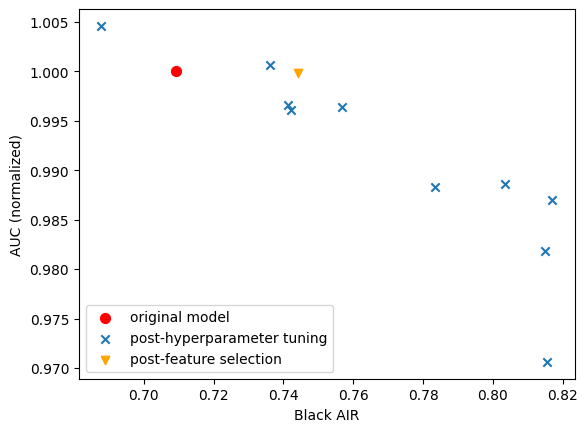

In [125]:
original_auc = feature_selection_results.loc['original model']['AUC']
original_black_air = feature_selection_results.loc['original model']['Black AIR']

new_auc = feature_selection_results.loc[feature_to_drop]['AUC']
new_black_air = feature_selection_results.loc[feature_to_drop]['Black AIR']

fig, ax = plt.subplots()
ax.scatter(original_black_air, 1.0, s=50, color='red', label='original model')
ax.scatter(results['mean_test_Black AIR'], results['mean_test_AUC']/original_auc, label='post-hyperparameter tuning', marker='x')
ax.scatter(new_black_air, new_auc/original_auc, color='orange', label='post-feature selection', marker='v')
ax.legend(loc='lower left')
ax.set_xlabel('Black AIR')
ax.set_ylabel(f'AUC (normalized)')

#fig.savefig('../Data/Data/Figures/model_tuning_scatter.svg', dpi=300)

In [126]:
results[['mean_test_Black AIR', 'mean_test_Hispanic AIR', 'mean_test_AUC']].sort_values(['mean_test_Black AIR', 'mean_test_AUC'], ascending=False)
highest_air_idx = results.loc[results['mean_test_Black AIR'] == results['mean_test_Black AIR'].max()].index[0]

# We can also choose the fairest model that demonstrates no more than a 1% decrease in AUC from the original model.
business_viable_models = results.loc[results['mean_test_AUC'] >= 0.99*original_auc]
alternative_model_idx = business_viable_models.loc[business_viable_models['mean_test_Black AIR'] == business_viable_models['mean_test_Black AIR'].max()].index[0]


In [127]:
new_hyperparameter_idx = [highest_air_idx, alternative_model_idx]

tuned_params = ['_'.join(col.split('_')[1:]) for col in results.columns if col.startswith('param_')]
new_hyperparameters = [dict(zip(tuned_params, [row[f'param_{param}'] for param in tuned_params])) for _, row in results.loc[new_hyperparameter_idx].iterrows()]

## 5.Conclusion

In [128]:
def model_summary(y_true, y_pred, group_info, reference_group, metric_dict, cutoff,
                  confusion_metrics_to_show=['False Positive Rate']):
    """
    Function to put all things together.

    """

    groups = np.unique(group_info)
    protected_groups = [group for group in groups if group != reference_group]

    model_metrics = perf_metrics(y_true, y_score=y_pred)
    # best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']
    # f1 = model_metrics['f1'].max()

    f1 = model_metrics.loc[model_metrics['cutoff'] == cutoff, 'f1'].values[0]

    auc = sklearn.metrics.roc_auc_score(y_true, y_score=y_pred)

    data = pd.DataFrame({'demo': group_info,
                        'y_true': y_true,
                        'y_pred': y_pred},
                        index=np.arange(len(y_pred)))

    disparity_table = fair_lending_disparity(data, y='y_true', yhat='y_pred',
                       demo_name='demo', groups=groups, reference_group=reference_group,
                       cutoff=cutoff)

    airs = dict(zip([f'{group} AIR' for group in protected_groups],
                    [disparity_table.loc[group]['AIR'] for group in protected_groups]))

    confusion_mats = {level: get_confusion_matrix(data, 'y_true', 'y_pred', by='demo',
                                                  level=level, cutoff=cutoff) for level in groups}
    confusion_metrics = confusion_matrix_metrics(confusion_mats, metric_dict)
    confusion_disparity_frame = confusion_metrics/confusion_metrics.loc[reference_group, :]

    confusion_metric_disparities = dict()
    for metric in confusion_metrics_to_show:
        confusion_metric_disparities.update(dict(zip([f"{group} {metric} Disparity" for group in protected_groups],
                                               [confusion_disparity_frame.loc[group][metric] for group in protected_groups])))

    output = {'AUC': auc, 'F1': f1}
    output.update(airs)
    output.update(confusion_metric_disparities)

    return pd.Series(output)

In [129]:

feature_selection_model = xgb.XGBClassifier(n_estimators=150,
                                     max_depth=5,
                                     learning_rate=0.05,
                                     subsample=0.6,
                                     colsample_bytree=1.0,
                                     monotone_constraints=new_monotone_constraints,
                                     random_state=12345,
                                     use_label_encoder=False,
                                     base_score=params['base_score'],
                                     eval_metric='logloss').fit(train[new_features], train[target])

model_metrics = perf_metrics(y_true=valid[target],
                             y_score=feature_selection_model.predict_proba(valid[new_features])[:, 1])
best_cut_feature_selection = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

hyp_tuning_model_1 = xgb.XGBClassifier(random_state=12345,
                                     use_label_encoder=False,
                                     eval_metric='logloss', **new_hyperparameters[0]).fit(train[new_features], train[target])

model_metrics = perf_metrics(y_true=valid[target],
                             y_score=hyp_tuning_model_1.predict_proba(valid[new_features])[:, 1])
best_cut_hyp_1 = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']


In [130]:
model_predictions = {'Original Model': (test[f"p_{target}"].values, best_cut_original),
                    'Pre-processing (reweighting)': (test[f'p_{target}_reweighted'].values, reweighted_best_cut),
                    'Feature selection': (feature_selection_model.predict_proba(test[new_features])[:, 1], best_cut_feature_selection),
                    'HPT :1 Fairest Model': (hyp_tuning_model_1.predict_proba(test[new_features])[:, 1], best_cut_hyp_1)}

In [131]:
model_summaries = {name: model_summary(test[target].values, pred, test['RACE'].values, 'white', metric_dict, cutoff) for name, (pred, cutoff) in model_predictions.items()}

Put your money on the models!

<img src="https://raw.githubusercontent.com/anilkumarpanda/fairness_cb/development/img/banker_cat.JPG" alt="Alt Text" height="400">

In [132]:
pd.DataFrame(model_summaries)

,Original Model,Pre-processing (reweighting),Feature selection,HPT :1 Fairest Model,HPT :2 Balance Fairness & Performance
AUC,0.798021,0.774183,0.797626,0.786818,0.796085
F1,0.558874,0.543758,0.559360,0.546980,0.556863
asian AIR,1.012274,1.010014,1.012145,1.012718,1.013949
black AIR,0.735836,0.877673,0.763933,0.822186,0.769588
hispanic AIR,0.736394,0.861252,0.752730,0.814116,0.752176
asian False Positive Rate Disparity,0.872567,0.929948,0.871232,0.910471,0.868501
black False Positive Rate Disparity,1.783528,0.956640,1.750689,1.229030,1.652653
hispanic False Positive Rate Disparity,1.696062,0.899065,1.646560,1.173908,1.572391


However we’ll need to remember that legal liability can come into play with ML bias issues.

There are many legal liabilities associated with bias in ML systems, and since we’re not lawyers (and likely neither are you), we need to be humble about the complexity of law, not let the Dunning-Kruger effect take over, and defer to actual experts on nondiscrimination law.

If we have any concerns about legal problems in our ML systems, now is the time to reach out to our managers or our legal department.



## 6.References

Most of the code and knowledge is borrowed from the following sources :

1. [Fairness Tree](https://docs.google.com/presentation/d/1ycNhDJr5uQiBhWvdlNArnv7ojydW73qryOjRBB30Z44/edit#slide=id.g8d5290cc44_0_417)
2. [Machine Learning for High-Risk Applications](https://learning.oreilly.com/library/view/machine-learning-for/9781098102425/)
3. [SHAP for Fairness](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Explaining%20quantitative%20measures%20of%20fairness.html)